In [219]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Model

print(tf.__version__)

2.4.1


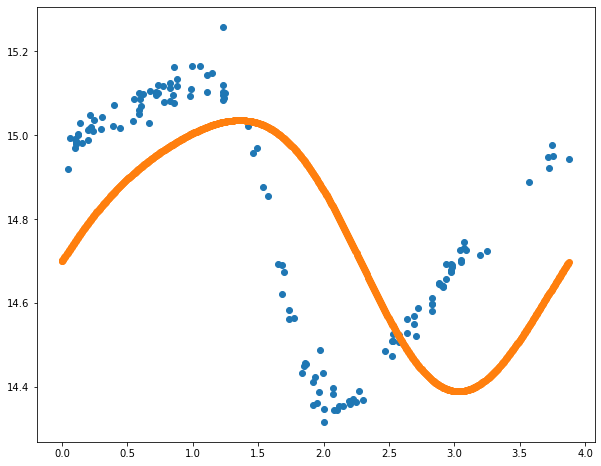

In [220]:
#como empieza
fig = plt.figure(figsize=(10, 8))
fig.set_facecolor('white')
plt.scatter(lc_g.mjd%period, lc_g.magpsf_corr)

t = np.linspace(0, period, 1000)
A = -0.1
B = 0.3
C = 0.05
D = 0.0
E = 14.75

y = (A*tf.math.cos((2*np.pi*tf.cast(x, dtype=tf.float32))/period)
+ B*tf.math.sin((2*np.pi*tf.cast(x, dtype=tf.float32))/period) 
+ C*tf.math.cos((2*np.pi*2*tf.cast(x, dtype=tf.float32))/period)
+ D*tf.math.sin((2*np.pi*2*tf.cast(x, dtype=tf.float32))/period)
+ E)

plt.scatter(t%period, y)

In [221]:
#modelo lineal
class LinearModel(Model):
    def __init__(self, A, B, C, D, E):
        super(LinearModel, self).__init__()
        self.A = tf.Variable(A, dtype=tf.float32)
        self.B = tf.Variable(B, dtype=tf.float32)
        self.C = tf.Variable(C, dtype=tf.float32)
        self.D = tf.Variable(D, dtype=tf.float32)
        self.E = tf.Variable(E, dtype=tf.float32)
        self.parameters = [self.A, self.B, self.C, self.D, self.E]
        
    def call(self, x):
        y = (self.A*tf.math.cos((2*np.pi*tf.cast(x, dtype=tf.float32))/period) 
             + self.B*tf.math.sin((2*np.pi*tf.cast(x, dtype=tf.float32))/period) 
             + self.C*tf.math.cos((2*np.pi*2*tf.cast(x, dtype=tf.float32))/period)
             + self.D*tf.math.sin((2*np.pi*2*tf.cast(x, dtype=tf.float32))/period) 
             + self.E)
        return y

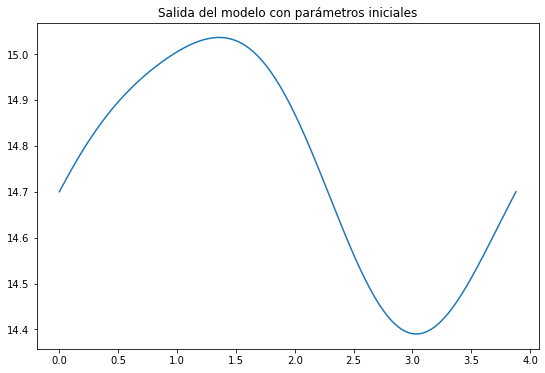

In [222]:
#parametros iniciales
A = -0.1
B = 0.3
C = 0.05
D = 0.0
E = 14.75
my_linear_model = LinearModel(A, B, C, D, E)
x = np.linspace(0, period, 1000)
y = my_linear_model(x)

plt.figure(figsize=(9, 6))
plt.plot(x, y)
plt.title('Salida del modelo con parámetros iniciales')
plt.gcf().patch.set_facecolor('white')

In [223]:
#minimizar mse
def mse_error(prediction, target):
    return tf.reduce_mean((prediction - target)**2)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.0)

def train_step(xs, targets):
    with tf.GradientTape() as tape:
        predictions = my_linear_model(xs)
        error = mse_error(predictions, targets)
    gradients = tape.gradient(error, my_linear_model.parameters)
    print(gradients)
    optimizer.apply_gradients(zip(gradients, my_linear_model.parameters))

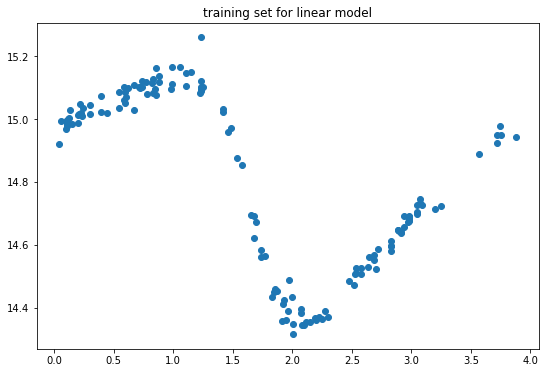

In [224]:
#conjunto de entrenamiento
alerts = pd.read_pickle('alerts.pkl')
slice_alerts = alerts[['mjd', 'magpsf_corr', 'sigmapsf_corr', 'fid']]

light_curve = slice_alerts.loc[['ZTF17aaajtgd']] 
lc_g = light_curve[light_curve.fid == 1]
period = 3.879

train_x = lc_g.mjd%period
train_y= lc_g.magpsf_corr
train_y = train_y.astype(np.float32)

plt.figure(figsize=(9, 6))
plt.scatter(train_x, train_y)
plt.title('training set for linear model')
plt.gcf().patch.set_facecolor('white')

In [225]:
#entrenamiento del modelo

iteration_log = []
error_log = []
for epoch in range(100):
    if epoch % 10 == 0:
        print('epoch', epoch)
    train_step(train_x, train_y)
    train_error = mse_error(my_linear_model(train_x), train_y)
    iteration_log.append(epoch)
    error_log.append(train_error)

epoch 0
ListWrapper([<tf.Tensor: shape=(), dtype=float32, numpy=-0.30505225>, <tf.Tensor: shape=(), dtype=float32, numpy=0.016622778>, <tf.Tensor: shape=(), dtype=float32, numpy=0.22885244>, <tf.Tensor: shape=(), dtype=float32, numpy=-0.016942669>, <tf.Tensor: shape=(), dtype=float32, numpy=-0.07047869>])
ListWrapper([<tf.Tensor: shape=(), dtype=float32, numpy=-0.29000446>, <tf.Tensor: shape=(), dtype=float32, numpy=0.017349912>, <tf.Tensor: shape=(), dtype=float32, numpy=0.21292289>, <tf.Tensor: shape=(), dtype=float32, numpy=-0.01251835>, <tf.Tensor: shape=(), dtype=float32, numpy=-0.06299809>])
ListWrapper([<tf.Tensor: shape=(), dtype=float32, numpy=-0.2757498>, <tf.Tensor: shape=(), dtype=float32, numpy=0.017959578>, <tf.Tensor: shape=(), dtype=float32, numpy=0.19807993>, <tf.Tensor: shape=(), dtype=float32, numpy=-0.008505033>, <tf.Tensor: shape=(), dtype=float32, numpy=-0.05637713>])
ListWrapper([<tf.Tensor: shape=(), dtype=float32, numpy=-0.262245>, <tf.Tensor: shape=(), dtype=f

<Figure size 648x432 with 0 Axes>

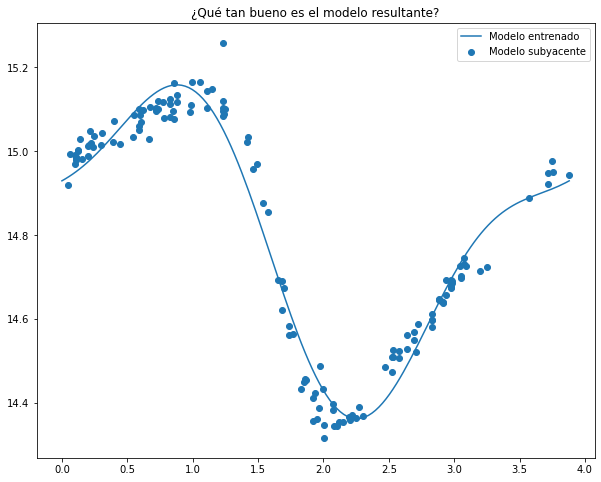

In [226]:
x_grid = np.linspace(0, period, 145)
model_output = my_linear_model(x_grid)

plt.figure(figsize=(9, 6))
fig = plt.figure(figsize=(10, 8))
fig.set_facecolor('white')
plt.scatter(lc_g.mjd%period, lc_g.magpsf_corr, label='Modelo subyacente')
plt.plot(x_grid, model_output, label='Modelo entrenado')
plt.title('¿Qué tan bueno es el modelo resultante?')
plt.legend()
plt.gcf().patch.set_facecolor('white')

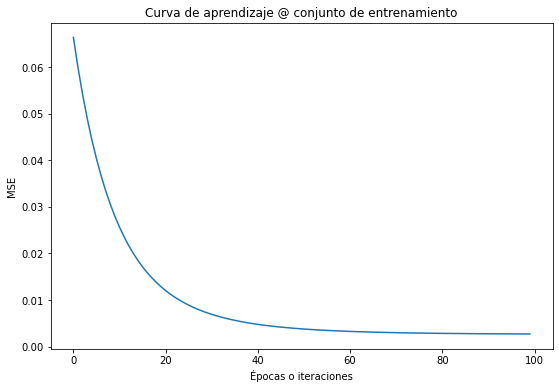

In [227]:
plt.figure(figsize=(9, 6))
plt.plot(iteration_log, error_log)
plt.xlabel('Épocas o iteraciones')
plt.ylabel('MSE')
plt.title('Curva de aprendizaje @ conjunto de entrenamiento')
plt.gcf().patch.set_facecolor('white')

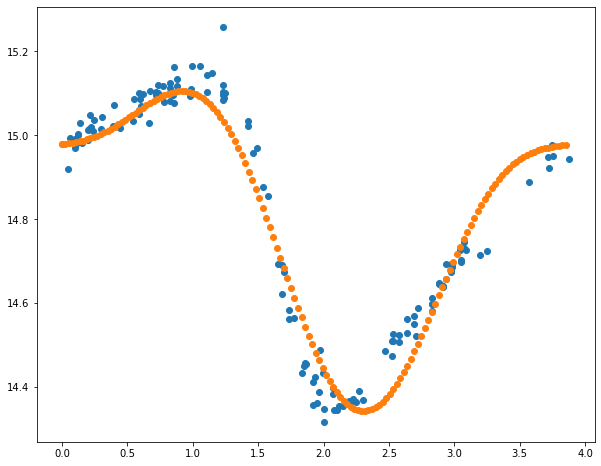

In [228]:
#como termina
fig = plt.figure(figsize=(10, 8))
fig.set_facecolor('white')
plt.scatter(lc_g.mjd%period, lc_g.magpsf_corr)

t = np.linspace(0, period, 145)
A = my_linear_model.parameters[0]
B = my_linear_model.parameters[1]
C = my_linear_model.parameters[2]
D = my_linear_model.parameters[3]
E = my_linear_model.parameters[4]

y = (A*np.sin(2*np.pi*1/period*t) 
     + B*np.cos(2*np.pi*1/period*t) 
     + C*np.sin(2*np.pi*2/period*t)
     + D*np.cos(2*np.pi*2/period*t) 
     + E)

plt.scatter(t%period, y)